\begin{equation}
    u_{ff} = \sqrt{\frac{2}{\rho(r)} \int_{r_{in}}^{r} \frac{g(r') S(r') \rho(r')}{c_p} dr'}
\end{equation}

Version of input file was 1.
Converting current equation_coefficients instance's version to 2.
/home/bjlazard/Rayleigh_Data/NR_project1/Shell_Slices/Shell_Slices/model_2_Shell_Avgs.dat
Version of input file was 1.
Converting current equation_coefficients instance's version to 2.
/home/bjlazard/Rayleigh_Data/NR_project1/Shell_Slices/Shell_Slices/model_7_Shell_Avgs.dat
0.8689695492128676


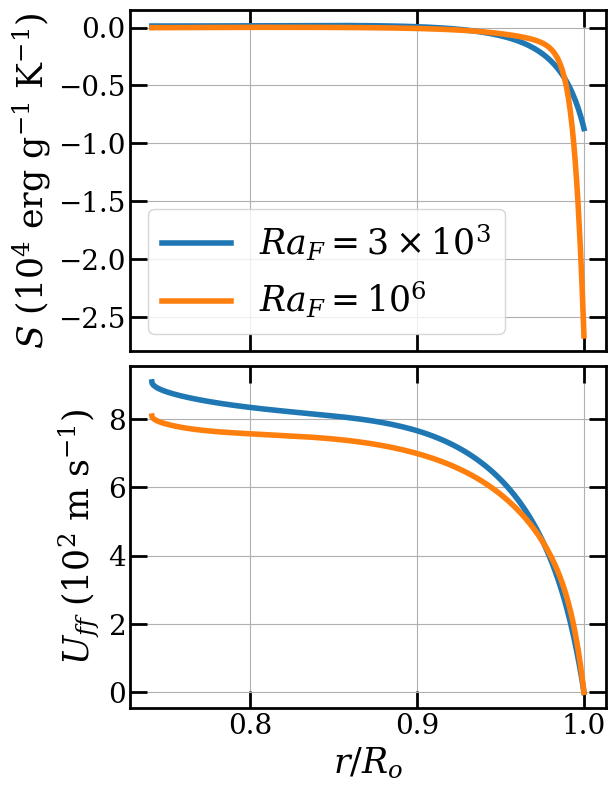

In [8]:
from rayleigh_diagnostics import G_Avgs, Shell_Slices, GridInfo
from New_Shell_Avgs import Shell_Avgs
from New_Shell_Spectra import Shell_Spectra
from reference_tools import equation_coefficients, run_int, vol_avg
import survey_utilities as su
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import *
import matplotlib as mpl
import spectral_utils
from scipy.optimize import curve_fit


def U_bff(eqf, saf):
    '''
    This routine calculate the non rotating free fall velocity for an anelastic system
    given the equation coefficients file and shell averages file from Rayleigh's outputs
    
    Inputs:
    eqf: string, path to the equation coefficients file
    saf: string, path to the shell averages file

    Outputs:
    radius: numpy array, the radius of the shell
    U_ff: numpy array, the non rotating free fall velocity
    S: numpy array, the entropy profile of the shell
    '''
    #Import necessary modules
    from reference_tools import equation_coefficients
    import numpy as np
    from New_Shell_Avgs import Shell_Avgs

    #Read in equation coefficients file
    equation = equation_coefficients(file = eqf)

    #Read in shell averages file
    sa = Shell_Avgs(saf, path = '')

    #Read in simulation parameters from equation coefficients file\
    #Note all the following quantities from top of the shell to the bottom of the shell. We reverse them in order to run our integral function and account for them later
    radius = equation.radius[::-1]
    rho = equation.functions[0,:][::-1]
    g_over_cp = equation.functions[1][::-1]/rho

    #calculate layer depth, surface area and volume average of g_over_cp
    H = np.max(radius) - np.min(radius)
    fpr = 4*np.pi*radius*radius
    gcp_volav = su.vol_avg(g_over_cp, radius)

    #Read in entropy: S(r) and calculate the entropy difference
    entropy = sa.lut[501]
    S = sa.vals[:, 0, entropy]
    S = S[::-1]
    S = S.transpose()
    S = S[0]
    ds = float(np.max(S) - np.min(S))

 
    #Run integral according to the equation in the markdown cell above to get u_ff
    U_ff = np.sqrt((-2/rho)*run_int((rho*g_over_cp*(S - np.max(S))) / (fpr), radius))

    return (radius, U_ff, S)


#Locations of the equation coefficients and shell averages files
direc = '/home/bjlazard/Rayleigh_Data/NR_project1/eq_coeff/eq_2'
prefix = '/home/bjlazard/Rayleigh_Data/NR_project1/Shell_Slices/Shell_Slices/model_2_Shell_Avgs.dat'

direc1 = '/home/bjlazard/Rayleigh_Data/NR_project1/eq_coeff/eq_7'
prefix1 = '/home/bjlazard/Rayleigh_Data/NR_project1/Shell_Slices/Shell_Slices/model_7_Shell_Avgs.dat'

#Set up the figure and axes
fig, ax = plt.subplots(2, 1, sharex = True, figsize = (6, 8))
ax[0].tick_params(which='minor', top = True, direction = 'in', length = 6, width = 2, right = True, labelsize = 20)
ax[0].tick_params(which='major', top = True, direction = 'in', length = 12, width = 2, right = True, labelsize = 20)
ax[1].tick_params(which='minor', top = True, direction = 'in', length = 6, width = 2, right = True, labelsize = 20)
ax[1].tick_params(which='major', top = True, direction = 'in', length = 12, width = 2, right = True, labelsize = 20)
plt.setp(ax[0].spines.values(), linewidth=2)
plt.setp(ax[1].spines.values(), linewidth=2)
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"


radius, u_ff_lowRa, S_lowRa = U_bff(direc, prefix)
radius, u_ff_highRa, S_highRa = U_bff(direc1, prefix1)
print(radius[63] / radius[-1])
######### SUBPLOT 1: Entropy profile ##################
ax[0].plot(radius / radius[-1], S_lowRa /  10000, linewidth = 4, label = r'$Ra_F = 3 \times 10^3$')
ax[0].plot(radius / radius[-1], S_highRa / 10000, linewidth = 4, label = r'$Ra_F = 10^6$')
#ax[0].set_xlabel(r'$r/R_o$', fontsize = 30)
ax[0].set_ylabel(r'$S~(10^4~\mathrm{erg~g^{-1}~K^{-1}})$', fontsize = 25)
ax[0].grid()
ax[0].legend(fontsize = 25)

######### SUBPLOT 2: Non-rotating free fall velocity ##################
ax[1].plot(radius / radius[-1], np.abs(u_ff_lowRa - np.max(u_ff_lowRa)) /10000 , linewidth = 4,label = r'$Ra_F = 1 \times 10^3$')
ax[1].plot(radius / radius[-1], np.abs(u_ff_highRa - np.max(u_ff_highRa)) /10000  ,linewidth = 4, label = r'$Ra_F = 10^6$')
ax[1].set_xlabel(r'$r/R_o$', fontsize = 25)
ax[1].set_ylabel(r'$U_{ff}~(10^2~\mathrm{m~s^{-1}})$', fontsize = 25)
ax[1].grid()
plt.tight_layout()

plt.savefig('U_ff_and_entropy.pdf', bbox_inches='tight')
